In [80]:
# The purpose of this code is to merge our scrapped GoodReads results 
# with Kaggle's GoodReads data, and compare how much the ratings have changed

import pandas as pd
import numpy as np
import re
from difflib import SequenceMatcher
import time
import matplotlib.pyplot as plt

In [66]:
# Load Kaggle dataset of book ratings
# Downloaded from: https://www.kaggle.com/gnanesh/goodreads-book-reviews
# NOTE THAT THIS DATASET IS NOT IN THE REPO AS IT IS OVER 304MB 
# AND THERE ARE TERMS TO AGREE ON KAGGLE TO WORK ON THIS DATASET

kaggle_book_reviews = pd.read_csv('../input_csv/br.csv', sep=',', encoding='utf8', engine='python', error_bad_lines=False)
kaggle_book_reviews.shape

Skipping line 312075: unexpected end of data


(312073, 9)

In [67]:
# FYI: only one line gave problems in reading the file in

kaggle_book_reviews.head()

,bookID,title,author,rating,ratingsCount,reviewsCount,reviewerName,reviewerRatings,review
0,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.73,22,1,Charles G,3.0,NaN
1,8,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",J.K. Rowling,4.77,34107,156,✿Katherine Elizabeth✿,5.0,NaN
2,3,Harry Potter and the Sorcerer's Stone,J.K. Rowling,4.44,4911929,77741,Lora,5.0,I'm going to keep this brief since there isn't...
3,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.54,1810404,28053,Cait (Paper Fury),5.0,"""Read Harry Potter!"" they said. ""It'll be fun!..."
4,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.47,1862749,29308,Diane ϟ [ Lestrange ],5.0,NaN


In [68]:
# Drop unnecessary columns:
kaggle_book_reviews = kaggle_book_reviews[['title','author','rating','ratingsCount']]
kaggle_book_reviews.head()

,title,author,rating,ratingsCount
0,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.73,22
1,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",J.K. Rowling,4.77,34107
2,Harry Potter and the Sorcerer's Stone,J.K. Rowling,4.44,4911929
3,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.54,1810404
4,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.47,1862749


In [69]:
# Let's clean up the titles a bit as well
kaggle_book_reviews['title'] = [re.split(r'\s{2,}', s.strip())[0] for s in list(kaggle_book_reviews['title'])]
kaggle_book_reviews.head()

,title,author,rating,ratingsCount
0,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.73,22
1,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",J.K. Rowling,4.77,34107
2,Harry Potter and the Sorcerer's Stone,J.K. Rowling,4.44,4911929
3,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.54,1810404
4,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.47,1862749


In [70]:
# There are lots of duplicate titles; let's clean them up!

kaggle_book_reviews = kaggle_book_reviews.sort_values(['title']) # have to use deprecated sort_values() here b/c of my version of Python (instead of sort())
kaggle_book_reviews.drop_duplicates(subset="title", inplace=True)
print(kaggle_book_reviews.shape)
kaggle_book_reviews.head()

(282731, 4)


,title,author,rating,ratingsCount
239779,!Vaya! Nuevo,Michael Buckby,0.00,0
156325,"""""All the World Is Here!"""": The Black Presence...",Christopher Robert Reed,2.67,3
202567,"""""City of the Century"""": A History of Gary, In...",James B. Lane,3.89,9
64623,"""""We Only Come Here to Struggle"""": Stories fro...",Berida Ndambuki,3.17,6
257999,"""...das heilige Evangelion in Schwang zu bring...",Reiner Nägele,0.00,0


In [ ]:
# Certainly requires more work to clean the titles up... 
# Will leave it for another day...

In [24]:
# Load Purnima's Wikipedia-scrapped list of movies adapted from science fiction books:
adapted_books = pd.read_csv('../input_csv/merged_list.csv', engine='python', encoding='utf8').drop(['Unnamed: 0'],axis=1)
print('There are '+ str(adapted_books.shape[0]) + ' films adapted from books')
adapted_books.head()


There are 199 films adapted from books


,movie,books,rating,average_votes
0,Around the World in Eighty Days,Around the World in Eighty Days (Extraordinary...,3.92,156130
1,Body Snatchers,Invasion of the Body Snatchers,3.89,17377
2,Frankenstein,Frankenstein,3.77,992321
3,The Invisible Man,Invisible Man,3.85,139972
4,Journey to the Center of the Earth,Journey to the Center of the Earth (Extraordin...,3.85,126382


In [72]:
# cleaning up trailing white spaces and strings not part of the actual title (these are easily
# found as there are usually more than 2 whitespaces after the title)
adapted_books_list = [re.split(r'\s{2,}', s.strip())[0] for s in list(adapted_books['books'])]
adapted_books_list

['Around the World in Eighty Days (Extraordinary Voyages, #11)',
 'Invasion of the Body Snatchers',
 'Frankenstein',
 'Invisible Man',
 'Journey to the Center of the Earth (Extraordinary Voyages, #3)',
 'The Mysterious Island (Extraordinary Voyages, #12)',
 'Nineteen Eighty-Four',
 'Planet of the Apes',
 'Twenty Thousand Leagues Under the Sea (Extraordinary Voyages, #6)',
 'Retirement Village of the Damned',
 'The War of the Worlds',
 'Escape to Witch Mountain',
 'The 5th Wave (The 5th Wave, #1)',
 'The 27th Day',
 '2010: The Year We Make Contact',
 '20,000 Leagues Under the Sea',
 'Action Replayy',
 'Aelita',
 'Altered States (Altered States, #0.5)',
 'The Amphibian',
 'Andromeda Nebula',
 'The Andromeda Strain',
 'Anna to the Infinite Power',
 'Annihilation (Southern Reach, #1)',
 'Atlas Shrugged (SparkNotes Literature Guides)',
 'Atlas Shrugged, Part A',
 'Atragon',
 'Babylon A.D.',
 'Battle Royale',
 'Battlefield Earth: A Saga of the Year 3000',
 'Blademage Beastmaster (Blademage, 

In [45]:
# Testing

# As one can see, the strings of titles may be hard to match against; 
# we need to use the SequenceMatcher in difflib library to get a similarity ratio:

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def mostsimilar(sentence, alist):
    scores = [similar(sentence, sentence_in_list) for sentence_in_list in alist]
    max_score = max(scores)
    result = pd.DataFrame({
        'row_index': [scores.index(max_score)]
        ,'max_score': [max_score]
        })
    return result

# Find the rows in Kaggle's dataframe (kaggle_book_reviews) 
# with the highest match for the scrapped movie-adapted sci-fi titles dataframe (adapted_books)

# Time how long it takes (approx) to search one title:
indexes_for_movies = pd.DataFrame()
kaggle_titles = list(kaggle_book_reviews['title'])
bookTitle = adapted_books['books'][0]
t0 = time.time()
#for bookTitle in list(adapted_books['books']):
indexes_for_movies = indexes_for_movies.append(mostsimilar(bookTitle, kaggle_titles))
t1 = time.time()
total_time = t1-t0

print(indexes_for_movies)


   max_score  row_index
0        1.0      20478


In [43]:
# Testing (cont'd)
bookTitle

'Around the World in Eighty Days (Extraordinary Voyages, #11)'

In [44]:
# Testing (cont'd)
kaggle_book_reviews.iloc[indexes_for_movies['row_index'],0]

52625    Around the World in Eighty Days (Extraordinary...
Name: title, dtype: object

In [46]:
# Testing (cont'd)
print(total_time)

73.00290131568909


In [ ]:
# So ~4 hours to search all 199 book titles...
# Doable... but I am too impatient...
# We'll focus on exact title matches (see below)

In [73]:
exact_kaggle_matches = kaggle_book_reviews.loc[kaggle_book_reviews['title'].isin(adapted_books_list)]
print('Found ' + str(exact_kaggle_matches.shape[0]) + ' out of ' + str(len(adapted_books_list)) + ' adapted scifi book titles')
exact_kaggle_matches.head()

Found 81 out of 199 adapted scifi book titles


,title,author,rating,ratingsCount
292963,"20,000 Leagues Under the Sea",Jules Verne,3.86,151037
21963,A Clockwork Orange,Anthony Burgess,3.98,460568
198026,"A Princess of Mars (Barsoom, #1)",Edgar Rice Burroughs,3.80,43311
12799,A Scanner Darkly,Philip K. Dick,4.04,62350
147746,"A Wrinkle in Time (Time Quintet, #1)",Madeleine L'Engle,4.04,663124


In [75]:
# Intersect the scrapped GoodReads ratings and Kaggle titles to see how the ratings differ between the two:
merged_df = pd.merge(exact_kaggle_matches, adapted_books, left_on='title', right_on='books', how='inner').drop_duplicates(subset='title')
print(merged_df.shape)
merged_df

(81, 8)


,title,author,rating_x,ratingsCount,movie,books,rating_y,average_votes
0,"20,000 Leagues Under the Sea",Jules Verne,3.86,151037,"20,000 Leagues Under the Sea","20,000 Leagues Under the Sea",3.84,1779
1,A Clockwork Orange,Anthony Burgess,3.98,460568,A Clockwork Orange,A Clockwork Orange,3.99,517714
2,"A Princess of Mars (Barsoom, #1)",Edgar Rice Burroughs,3.80,43311,Princess of Mars,"A Princess of Mars (Barsoom, #1)",3.80,46302
3,A Scanner Darkly,Philip K. Dick,4.04,62350,A Scanner Darkly,A Scanner Darkly,4.03,72874
4,"A Wrinkle in Time (Time Quintet, #1)",Madeleine L'Engle,4.04,663124,A Wrinkle in Time,"A Wrinkle in Time (Time Quintet, #1)",4.02,829770
5,Aelita,Aleksey Nikolayevich Tolstoy,3.66,785,Aelita,Aelita,3.65,926
6,All the Light We Cannot See,Anthony Doerr,4.31,569524,We,All the Light We Cannot See,4.33,752045
7,Anna to the Infinite Power,Mildred Ames,3.91,517,Anna to the Infinite Power,Anna to the Infinite Power,3.91,549
8,Around the World in Eighty Days (Extraordinary...,Jules Verne,3.91,142833,Around the World in Eighty Days,Around the World in Eighty Days (Extraordinary...,3.92,156130
9,Atlas Shrugged (SparkNotes Literature Guides),SparkNotes,3.47,15,Atlas Shrugged series,Atlas Shrugged (SparkNotes Literature Guides),3.45,20


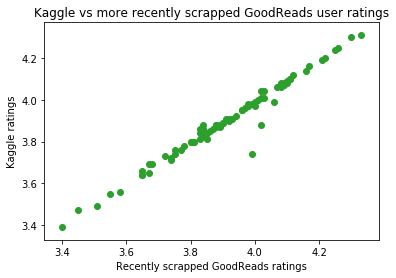

In [86]:
kaggle_ratings = merged_df['rating_x']
recently_scrapped_ratings = merged_df['rating_y']
plt.scatter(recently_scrapped_ratings, kaggle_ratings)
plt.title('Kaggle vs more recently scrapped GoodReads user ratings')
plt.xlabel('Recently scrapped GoodReads ratings')
plt.ylabel('Kaggle ratings')
plt.show()

In [79]:
# Compare the two ratings:
ratings_diff = abs(merged_df['rating_y'] - merged_df['rating_x'])
ratings_diff = list(ratings_diff)
ratings_diff

[0.020000000000000018,
 0.010000000000000231,
 0.0,
 0.0099999999999997868,
 0.020000000000000462,
 0.010000000000000231,
 0.020000000000000462,
 0.0,
 0.0099999999999997868,
 0.020000000000000018,
 0.0099999999999997868,
 0.019999999999999574,
 0.0099999999999997868,
 0.0099999999999997868,
 0.0099999999999997868,
 0.0099999999999997868,
 0.020000000000000018,
 0.0099999999999997868,
 0.0,
 0.0099999999999997868,
 0.0099999999999997868,
 0.0099999999999997868,
 0.019999999999999574,
 0.0,
 0.0099999999999997868,
 0.010000000000000231,
 0.010000000000000231,
 0.020000000000000018,
 0.069999999999999396,
 0.0099999999999997868,
 0.010000000000000231,
 0.010000000000000231,
 0.010000000000000231,
 0.020000000000000018,
 0.0099999999999997868,
 0.029999999999999805,
 0.020000000000000018,
 0.0,
 0.0099999999999997868,
 0.010000000000000675,
 0.029999999999999805,
 0.020000000000000018,
 0.010000000000000231,
 0.020000000000000018,
 0.020000000000000462,
 0.020000000000000018,
 0.0,
 0.010

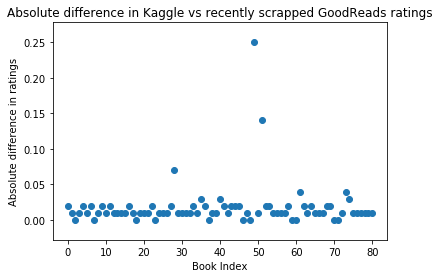

In [88]:
plt.scatter(np.arange(len(ratings_diff)), ratings_diff)
plt.title('Absolute difference in Kaggle vs recently scrapped GoodReads ratings')
plt.xlabel('Book Index')
plt.ylabel('Absolute difference in ratings')
plt.show()

In [ ]:
# The ratings do not appear to have changed much from Kaggle's dataset and our more recent scrapped ratings!